In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2021-08-02 19:09:57.654594: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-08-02 19:09:59.147097: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-08-02 19:10:01.279385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-02 19:10:01.280181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-08-02 19:10:01.280227: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-08-02 19:10:01.284192: I tensorflow/stream_executor/platform/defa

In [2]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)

In [4]:
!pip install segmentation-models

In [5]:
import tensorflow as tf
from tensorflow import keras 

import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

from keras.utils import conv_utils
from keras.backend import normalize_data_format
keras.backend.set_image_data_format('channels_last')
from keras.metrics import MeanIoU


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [6]:
pwd

'/home/jupyter/prpls-dl/deeplearning-prpls'

In [7]:
# import zipfile
!unzip '/home/jupyter/prpls-dl/tiles_zip.zip' -d '/tmp'

Archive:  /home/jupyter/prpls-dl/tiles_zip.zip
   creating: /tmp/test/
   creating: /tmp/test_mask/
   creating: /tmp/train/
   creating: /tmp/train_mask/
   creating: /tmp/val/
   creating: /tmp/val_mask/
  inflating: /tmp/test/test_img_634777_4866277.tif  
  inflating: /tmp/test/test_img_634777_4866280.tif  
  inflating: /tmp/test/test_img_634777_4866282.tif  
  inflating: /tmp/test/test_img_634777_4866284.tif  
  inflating: /tmp/test/test_img_634777_4866287.tif  
  inflating: /tmp/test/test_img_634777_4866289.tif  
  inflating: /tmp/test/test_img_634777_4866291.tif  
  inflating: /tmp/test/test_img_634777_4866293.tif  
  inflating: /tmp/test/test_img_634777_4866296.tif  
  inflating: /tmp/test/test_img_634777_4866298.tif  
  inflating: /tmp/test/test_img_634777_4866300.tif  
  inflating: /tmp/test/test_img_634777_4866303.tif  
  inflating: /tmp/test/test_img_634777_4866305.tif  
  inflating: /tmp/test/test_img_634777_4866307.tif  
  inflating: /tmp/test/test_img_634777_4866310.tif  

In [15]:
ls

__pycache__/
model1_and2_loss_graph.png
modelvgg19_256_80epo_loss_graph.png
resent34_50epochs_256.hdf5
systemd-private-e4cbd4fbe6574decbe10e1551a5c5945-chrony.service-7O9tYi/
systemd-private-e4cbd4fbe6574decbe10e1551a5c5945-haveged.service-EyUymf/
test/
test_256/
test_mask/
test_mask_256/
train/
train_256/
train_mask/
train_mask_256/
val/
val_256/
val_mask/
val_mask_256/
vgg19_80epochs_256.h5
vgg19_80epochs_256.hdf5
vgg19_80epochs_256.tf/


In [16]:
import fnmatch
import os

train_dirpath= '/tmp/train'
print('Number of training images:', len(fnmatch.filter(os.listdir(train_dirpath), '*.tif')))

label_dirpath= '/tmp/train_mask'
print('Number of label images:', len(fnmatch.filter(os.listdir(label_dirpath), '*.tif')))

Number of training images: 2680
Number of label images: 2680


In [ ]:
train_list=os.listdir('/tmp/train_256')
mask_list=os.listdir('/tmp/train_mask_256')
mask = []
img = []
for filename in train_list:
    if filename.endswith('/tmp/train_256/*.tif'):
        img.append(filename)

for filename in mask_list:
    if filename.endswith('/tmp/train_mask_256/*.tif'):
        mask.append(filename)

In [ ]:
# import glob
# train_images = []

# for dir_path in glob.glob(os.path.join(train_dirpath, "*.tif")):
#     img= cv2.imread(dir_path, cv2.IMREAD_COLOR)       
#     img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#     train_images.append(img)
    
# train_images = np.array(train_images)
# print(train_images.shape)

In [ ]:
# img.sort()
# # mask.sort()
# img = img[:680]
# # masks = mask[:680]

In [17]:
import rasterio

train_images = []

for dir_path in glob.glob(os.path.join(train_dirpath, "*.tif")):
    im_train = rasterio.open(dir_path)
    im_train = im_train.read()# read all raster values
    train_images.append(im_train)

train_images = np.array(train_images)
train_images = np.rollaxis(train_images, 1, 4)# to change the position of number of channels, which rasterio put in the second position instead of last.
print(train_images.shape)

(2680, 128, 128, 4)


In [18]:
import rasterio

train_masks = []

for dir_path in glob.glob(os.path.join(label_dirpath, "*.tif")):
    im_train = rasterio.open(dir_path)
    im_train = im_train.read()# read all raster values
    train_masks.append(im_train)

train_masks = np.array(train_masks)
train_masks = np.rollaxis(train_masks, 1, 4)
print(train_masks.shape)

(2680, 128, 128, 1)


In [ ]:
# y = np.zeros((680, 256, 256), dtype=np.uint8)
#X = np.zeros((680, 256, 256, 4), dtype=np.float32)

In [19]:
print(train_images.shape)
print(train_masks.shape)

(2680, 128, 128, 4)
(2680, 128, 128, 1)


In [25]:
print("Mask min=", train_masks.min())
print("Mask max=", train_masks.max())
print("train image min=", train_images.min())
print("train images max=", train_images.max())

Mask min= 0
Mask max= 3
train image min= -10000.0
train images max= 255.0


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size = 0.20, random_state=0)

In [27]:
import tensorflow as tf
from tensorflow import keras 

import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import model_from_json

from tensorflow.keras.layers import Input, Conv2D, Reshape
from tensorflow.keras.models import Model


In [28]:
from tensorflow.keras.utils import to_categorical

n_classes=4
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 3]


In [31]:
n_classes=4
activation='sigmoid'

LR = 0.0001
optim = keras.optimizers.Adam(LR)
total_loss = sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
#metrics = sm.metrics.IOUScore()

from tensorflow.keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)

from tensorflow.keras.layers import Reshape
N = X_train.shape[-1]
BACKBONE = 'vgg19'
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

model2 = sm.Unet(backbone_name=BACKBONE, encoder_weights=None, input_shape=(128, 128, N))

In [32]:
model2.compile(optimizer=optim, loss=total_loss, metrics=metrics)

import time
from datetime import datetime
start_time = datetime.now()
print('Start Time for Model: {}'.format(start_time))
history2 = model2.fit(X_train,y_train_cat,batch_size=32,epochs=50,validation_data=(X_test, y_test_cat), callbacks=[earlystopping])
end_time = datetime.now()
print('End Time for Model: {}'.format(end_time))
print('Duration for Model: {}'.format(end_time - start_time))

model1.save('vgg19_50epochs_256.hdf5')

Start Time for Model: 2021-08-02 19:15:23.670267
Epoch 1/50
67/67 [==============================] - 39s 589ms/step - loss: 0.8138 - iou_score: 0.1664 - f1-score: 0.2209 - val_loss: 0.8046 - val_iou_score: 0.1955 - val_f1-score: 0.2470
Epoch 2/50
67/67 [==============================] - 35s 519ms/step - loss: 0.7865 - iou_score: 0.2101 - f1-score: 0.2590 - val_loss: 0.7848 - val_iou_score: 0.2449 - val_f1-score: 0.2776
Epoch 3/50
67/67 [==============================] - 35s 518ms/step - loss: 0.7759 - iou_score: 0.2358 - f1-score: 0.2762 - val_loss: 0.7748 - val_iou_score: 0.2466 - val_f1-score: 0.2786
Epoch 4/50
67/67 [==============================] - 35s 518ms/step - loss: 0.7664 - iou_score: 0.2445 - f1-score: 0.2815 - val_loss: 0.7693 - val_iou_score: 0.2430 - val_f1-score: 0.2768
Epoch 5/50
67/67 [==============================] - 35s 518ms/step - loss: 0.7556 - iou_score: 0.2471 - f1-score: 0.2830 - val_loss: 0.7631 - val_iou_score: 0.2493 - val_f1-score: 0.2801
Epoch 6/50
67/67

NameError: name 'model1' is not defined

In [33]:
model2.save('vgg19_50epochs_128.hdf5')

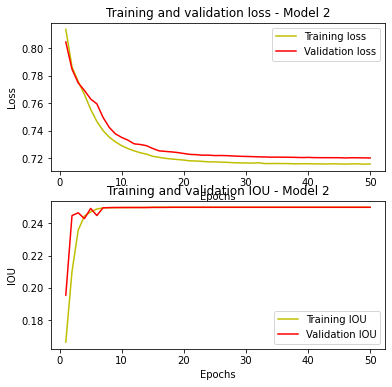

<Figure size 432x288 with 0 Axes>

In [34]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(6, 6))

# loss1 = history1.history['loss']
# val_loss1 =  history1.history['val_loss']
# epochs = range(1, len(loss1) + 1)
# ax1.plot(epochs, loss1, 'y', label='Training loss')
# ax1.plot(epochs, val_loss1, 'r', label='Validation loss')
# ax1.set_title('Training and validation loss - Model 1')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Loss')
# ax1.legend()


# acc1 =  history1.history['iou_score']
# val_acc1 =  history1.history['val_iou_score']
# ax2.plot(epochs, acc1, 'y', label='Training IOU')
# ax2.plot(epochs, val_acc1, 'r', label='Validation IOU')
# ax2.set_title('Training and validation IOU - Model 1')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('IOU')
# ax2.legend()

loss2 = history2.history['loss']
val_loss2 =  history2.history['val_loss']
epochs = range(1, len(loss2) + 1)
ax3.plot(epochs, loss2, 'y', label='Training loss')
ax3.plot(epochs, val_loss2, 'r', label='Validation loss')
ax3.set_title('Training and validation loss - Model 2')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend()


acc2 =  history2.history['iou_score']
val_acc2 =  history2.history['val_iou_score']
ax4.plot(epochs, acc2, 'y', label='Training IOU')
ax4.plot(epochs, val_acc2, 'r', label='Validation IOU')
ax4.set_title('Training and validation IOU - Model 2')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('IOU')
ax4.legend()

plt.show()
plt.savefig('modelvgg19_128_50epo_loss_graph.png')

In [35]:
model2.evaluate(X_test, y_test_cat)

17/17 [==============================] - 3s 154ms/step - loss: 0.7201 - iou_score: 0.2500 - f1-score: 0.2805


[0.7200803756713867, 0.25, 0.2805042266845703]

In [43]:
from tensorflow.keras.models import load_model

def f1(y_true, y_pred):
    return 1

#model1 = tf.keras.models.load_model('vgg19_80epochs_256.h5', custom_objects={'f1':f1})

#Set compile=False as we are not loading it for training, only for prediction.
model2 = load_model('vgg19_50epochs_128.hdf5', compile=False)
pred2 = model2.predict(X_test)
y_pred2_argmax=np.argmax(pred2, axis=3)

n_classes = 4
IOU1 = MeanIoU(num_classes=n_classes) 

IOU1.update_state(y_test[:,:,:, 0], y_pred2_argmax)
print('IOU Score for model1 = ', IOU1.result().numpy())

IOU Score for model1 =  0.30330077


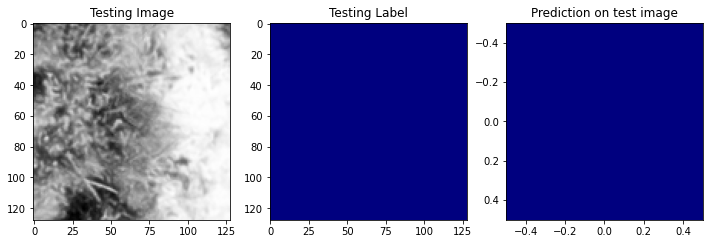

In [82]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

test_pred2 = model2.predict(test_img_input)

test_preds=np.array([test_pred2])
weighted_ensemble_test_prediction = np.argmax(test_preds, axis=3)[:,:,0]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(weighted_ensemble_test_prediction, cmap='jet')
plt.show()

